# Overview

Oftentimes, fraud occurs at the checkout section of a service. 

We can apply machine learning methods to behavioral data to identify fraudulent checkout activity. Presumably, there is some intrinsic pattern to the behavioral data - however obscure it might be - that can help identify when a checkout instance is likely fraudulent.

In this demo, we will build a machine learning model around data collected by Moonsense from registration, sign-in, and checkout activity to identify cases of fraudulent checkouts. We will also assess the overall performance of the model to determine its possible efficacy when deployed.

# Demo Design

(Note: this is an extension of the prior Registration ID Fraud and Sign In demos and includes many similar elements.)

For the purpose of this demonstration, we asked a set of users to engage with a Moonsense demo environment.

One of the sections of the demo environment includes a checkout screen. We asked users to complete this section a set number of times, using synthetically generated credit card details.

The bottom left of the page includes a `Client Session Group` ID, which is a unique identifer for the given interaction.

The bottom right of the page reflects the version of the web SDK that has been deployed.

We asked the users to record the Client Session Group ID each time they completed the data collection exercise. Later on, we can use the Client Group Session ID as a way to tag the data collected as either `legitimate` or `illegitimate`. 

Below is a snippet of some synthetic data we asked our users to input, followed by the Client Session Group ID that the user recorded.

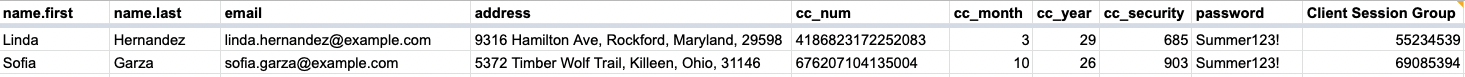

Once the input exercise was completed, we had a dataset made up of equal repetititions of legitimate and illegitimate records.

To minimize environmental variabilty, we asked our users to only input details using a computer rather than with mobile devices.



# Setup

Before we proceed further, we'll load up a few essential modules commonly used in the practice of data science.

In [1]:
import pandas as pd # useful for data manipulation
import numpy as np # useful for numerical interaction
import scipy.stats as stats # useful for statistical analysis
import json # interact with .json files
import os # interact with the local operating system
import glob # enumerate files and directory structures
import csv # interact with .csv files

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# suppress verbose warnings
import warnings
warnings.filterwarnings('ignore')

# Functions

Below are a collection of simple and explicit functions that facilitate interactions with the Moonsense data in this demo.

In [3]:
def get_raw_sealed_bundle_paths(data_path):
    """
    Given a top-level data path, this enumerates all the complete paths for the various raw_sealed_bundles.
    """
    total_path = data_path + "/**/raw_sealed_bundles.json"
    raw_sealed_bundles_paths = glob.glob(total_path, recursive=True)
    
    return raw_sealed_bundles_paths

In [4]:
def get_metadata_paths(data_path):
    """
    Given a top-level data path, this enumerates all the complete paths for the various metadata.json.
    """
    total_path = data_path + "/**/metadata.json"
    metadata_paths = glob.glob(total_path, recursive=True)
    
    return metadata_paths

In [10]:
def extract_gid(raw_sealed_bundles_path):
    """
    Based on the path, pull out the Client Session Group ID
    This works because the Client Session Group ID is part of the directory structure
    """
    gid = raw_sealed_bundles_path.split(os.sep)[4]
    
    return gid

In [11]:
def extract_sessionid(raw_sealed_bundles_path):
    """
    Based on the path, pull out the Session ID
    This works because the Session ID is part of the directory structure
    """
    sessionid = raw_sealed_bundles_path.split(os.sep)[3]
    
    return sessionid

In [12]:
def extract_target_sessionid(data_path, target):
    """
    Where 'target' is a label name.
    We're looking for sessions that contain a desired target. 
    Labels in demo include: "sign-in", "registration", "payment", "checkout", "interaction", ...
    """
    sessions = []
    
    all_metadata_json = get_metadata_paths(data_path)
    
    for file in all_metadata_json:
        with open(file, 'r') as f:
            out = json.load(f)
    
            label_names = []
            for item in out['labels']:
                label_names.append(item['name'])

            if target in label_names:
                sessions.append(out['sessionId'])
                
    return(sessions)
        

In [13]:
def single_session(raw_sealed_bundles_path, data_type = "key_press_data"):
    """
    For each session, generate a two-dimensional dataframe with details specific to the data_type collected.
    """

    gid = extract_gid(raw_sealed_bundles_path)
    
    json_list = []
    with open(raw_sealed_bundles_path, 'r') as f:
        for json_record in f:
            record_dict = json.loads(json_record)

            if data_type in record_dict['bundle']:
                json_list.append(record_dict['bundle']['key_press_data'])  
    
    df_agg = pd.DataFrame()
    
    for i in range(len(json_list)):
        df = pd.json_normalize(json_list[i])
        df_agg = df_agg.append(df)
    
    df_agg['gid'] = gid
    
    return df_agg

In [14]:
def multi_session(data_path, target = "", data_type = "key_press_data"):
    """
    Given a top level data path, generate a consolidated dataframe of all key_press_data.
    Target is optional, it grabs specific sessions based on matching label names. if absent, grab everything.
    data_type defaults to key_press_data. Something here is required.
    """
    
    # get all the paths of all the raw_sealed_bundles.json
    raw_paths = get_raw_sealed_bundle_paths(data_path)
    
    # target sessions
    if not target.strip():
        filtered_paths = raw_paths
    else:
        # take the raw path, filter it to session IDs that have targeted label names
        target_sessions = extract_target_sessionid(data_path, target)
        filtered_paths = [path for path in raw_paths if any(sessionid in path for sessionid in target_sessions)]
    
    df_multi = pd.DataFrame()
    
    for path in filtered_paths:
        df_single = single_session(path)
        df_multi = df_multi.append(df_single)
    
    return df_multi

In [15]:
def count_special_keys(data_path, target = "", data_type = "key_press_data"):
    """
    Get a count of all the special keys used for a given label, where the label is the "target"
    """
    df = multi_session(data_path, target)
    
    df_count = pd.pivot_table(df.loc[:,['gid', 'special_key']],
               values = 'special_key', index='gid', columns = 'special_key', aggfunc='value_counts')\
                .fillna(0) \
                .reset_index() \
                .rename(columns = {
        "Backspace":target+"_backspace",
        "Enter":target+"_enter",
        "Meta":target+"_meta",
        "Shift":target+"_shift",
        "Tab":target+"_tab",
        "ArrowLeft":target+"_arrowleft",
        "ArrowRight":target+"_arrowright",
        "Control":target+"_control",
        "Escape":target+"_escape"
    })
    
    return df_count

# Data

__For this exercise, we'll focus primarily on key press data__, though there is plenty more Moonsense-sourced data to pick from.

To access the data en masse, first we'll have to generate a secret authentication token through the Moonsense console by navigating to `Apps`, selecting the appropriate App, and creating a token.

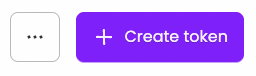

Once the token creation process is completed, a secret token and a public token will appear.


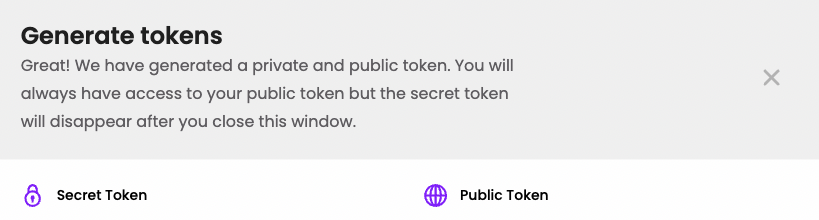

We recommend saving the tokens and then assigning the secret token to an environment variable.  The default token name that the Moonsense Python SDK searches for is called `MOONSENSE_SECRET_TOKEN`.

## Download

For convenience, we've provided a script `utils/download.py` that can programmatically download Moonsense data in bulk.

It accepts three optional arguments, including:
* A start date
* An end date
* A .csv file with a `group_id` that will filter the returned data to only include data with matching `Client Session Group` IDs.

In our case, we executed the script with the following:

```bash
python3 utils/download.py --since 2022-08-03 --until 2022-08-06 --filter_by inputs/filtered_list.csv
```

Where `inputs/filtered_list.csv` is a .csv containg `Client Session Group` IDs.


Note that the script seeks out a `MOONSENSE_SECRET_TOKEN` environment variable for authentication purposes.

Successful execution of the script downloads a mass of data:

```bash
> tree data -l 3

data
├── 2022-08-04
│   └── 33643170
│       ├── eHZQczKU7Kcj57g586kZda
│       │   ├── metadata.json
│       │   └── raw_sealed_bundles.json
│       └── mdHAbnakubRW5NMdbii8g8
│           ├── metadata.json
│           └── raw_sealed_bundles.json
└── 2022-08-05
    ├── 06136989
    │   ├── B8qd5qLumW6c4NQs9zj9xY
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json
    │   ├── NUtMTn28SqVZSxbt2zFopN
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json
    │   ├── QJEknkpX6HhUCj2rq7eWp7
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json

...
```
The path structure is of the form: `./data/<date>/<Client Session Group>/<session>/*.json`

## Reshape data

The data in its raw form is rich, but it still needs to be reshaped for any given purpose.

In our case, our aim is to focus on keystroke dynamics, which is contained in `key_press_data` within the raw data. We are especially interested in the timing patterns of key presses. `key_press_data` appears across numerous `Session` records spread across different `raw_sealed_bundle.json` files.

Our goal is to generate a [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), flat dataframe that includes all available data related to the key presses – the timings, the time differences from key press event to another, the keys themselves, the user behind the keys, and more.

To utilize many of the functions we've prepared, first we'll define a variable with the top level data path.

In [16]:
# specify the path to the data
top_data_path = "../../data/"

Next, we'll enumerate the full paths for all the `raw_sealed_bundles.json`.

In [17]:
raw_sealed_bundles = get_raw_sealed_bundle_paths(top_data_path)

In [18]:
# Preview a few records
raw_sealed_bundles[0:5]

['../../data/2022-08-04/33643170/eHZQczKU7Kcj57g586kZda/raw_sealed_bundles.json',
 '../../data/2022-08-04/33643170/mdHAbnakubRW5NMdbii8g8/raw_sealed_bundles.json',
 '../../data/2022-08-05/55234539/sw2iiW6f3aQ8JWubyRPKK7/raw_sealed_bundles.json',
 '../../data/2022-08-05/55234539/cFG2AY7xQG3m6ByAtWo2gc/raw_sealed_bundles.json',
 '../../data/2022-08-05/55234539/WEQjHuScQvsdwwZ94Yi3jD/raw_sealed_bundles.json']

This however grabs everything, including material that isn't strictly part of the checkout.

Each raw sealed bundle comes with a corresponding `metadata.json`, which provides a broad range of details, including _where_ the data originated from based on details contained within a `labels` key.

```bash
> tree data -l 3

data
├── 2022-08-04
│   └── 33643170
│       ├── eHZQczKU7Kcj57g586kZda
│       │   ├── metadata.json
│       │   └── raw_sealed_bundles.json
│       └── mdHAbnakubRW5NMdbii8g8
│           ├── metadata.json
│           └── raw_sealed_bundles.json
```

First, similar to the `raw_sealed_bundles.json`, we'll enumerate the `metadata.json` paths.

In [21]:
# get all the metadata paths
metadata_paths = get_metadata_paths(top_data_path)

In [22]:
metadata_paths[0:5]

['../../data/2022-08-04/33643170/eHZQczKU7Kcj57g586kZda/metadata.json',
 '../../data/2022-08-04/33643170/mdHAbnakubRW5NMdbii8g8/metadata.json',
 '../../data/2022-08-05/55234539/sw2iiW6f3aQ8JWubyRPKK7/metadata.json',
 '../../data/2022-08-05/55234539/cFG2AY7xQG3m6ByAtWo2gc/metadata.json',
 '../../data/2022-08-05/55234539/WEQjHuScQvsdwwZ94Yi3jD/metadata.json']

Let's inspect one of these up close.

In [23]:
with open(metadata_paths[0], 'r') as f:
    out = json.load(f)
    
    print(out)

{'sessionId': 'eHZQczKU7Kcj57g586kZda', 'appId': 'iznJpoSNZiub4WLaukazhQ', 'oldestEvent': '2022-08-04T18:20:04.394879570Z', 'newestEvent': '2022-08-04T18:23:56.843Z', 'createdAt': '2022-08-04T18:20:04.419039Z', 'metadata': {'platform': 'WEB', 'manufacturer': 'Chrome', 'model': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36', 'systemVersion': '103.0.0.0', 'isDevicePhysical': True, 'recordingProfile': {'name': 'fraud_and_risk', 'version': '1'}, 'releaseVersion': '0.7.1'}, 'counters': {'app_life_cycle': {'total': 4}, 'bundle': {'buckets': [{'startTime': '1659637380000', 'value': '5'}, {'startTime': '1659637260000', 'value': '3'}, {'startTime': '1659637200000', 'value': '11'}], 'total': 19}, 'custom_event': {'total': 1}, 'key_press': {'total': 2}, 'permission': {'total': 6}, 'pointer': {'total': 347}, 'viewport_size': {'total': 1}}, 'labels': [{'labelId': 'jyWrSmBNGYjiLZMDwh3jVH', 'name': 'registration'}, {'labelId': '

That's quite a bit of detail. Let's zoom in on the `labels` key.

In [24]:
out['labels']

[{'labelId': 'jyWrSmBNGYjiLZMDwh3jVH', 'name': 'registration'},
 {'labelId': 'tHgKseAziQjsK7NeDuSUA8', 'name': 'interaction'}]

That particular label indicates that the corresponding `raw_sealed_bundle.json` contains details associated with registration and interaction.

## Checkout Key Press

Since we're focused on checkout in this particular example, let's hone in on a label name of 'checkout'. The function we've written includes a parameter to specify a target to filter on.

In [25]:
checkout_sessions = extract_target_sessionid(top_data_path, target="checkout")

In [26]:
len(checkout_sessions)

114

In [27]:
checkout_sessions[0:5]

['cFG2AY7xQG3m6ByAtWo2gc',
 'zEXuBYFVRDVQGqMtB4HXQo',
 'hT3gZNidZpFWHAKN4H9yag',
 'pXFAabRXZqZHFPsMPBp3FZ',
 'UGbVL2P3xbvPGf95Xrxgm4']

Now we have the specific session IDs for checkouts. We can use that to filter down the set of `raw_sealed_bundles.json` paths to only those that include checkout data.

For demonstration purposes, let's look for only the first session ID that includes checkout details, and return the full path.

In [28]:
target_path = [path for path in metadata_paths if checkout_sessions[0] in path]

In [29]:
target_path[0]

'../../data/2022-08-05/55234539/cFG2AY7xQG3m6ByAtWo2gc/metadata.json'

In [30]:
with open(target_path[0], 'r') as f:
    out = json.load(f)

    print(out['labels'])

[{'labelId': 'YuF2Ct28QVi5ESXSK8J4T3', 'name': 'checkout'}, {'labelId': 'gTmdgi9UT2NbWF7bnWErTU', 'name': 'checkout'}, {'labelId': 'tHgKseAziQjsK7NeDuSUA8', 'name': 'interaction'}]


Note the presence of `'name': 'checkout'`, indicating that this session includes data associated with checkouts.

We'll use one of our defined functions to extract all the key press data associated with sessions that are linked to checkouts.

In [31]:
checkout_kp_df = multi_session(top_data_path, "checkout")

In [32]:
checkout_kp_df.head()

,determined_at,type,special_key,target.target_id,target.target_type,masked_key,gid,shift_key,meta_key
0,61419,KEY_UP,Enter,65cd98e7-9814-45c2-a30d-c667da9c35e4,body,NaN,55234539,NaN,NaN
0,65701,KEY_DOWN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1126.0,55234539,NaN,NaN
1,65788,KEY_DOWN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1049.0,55234539,NaN,NaN
2,65796,KEY_UP,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1126.0,55234539,NaN,NaN
3,65905,KEY_UP,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1049.0,55234539,NaN,NaN


In [33]:
len(checkout_kp_df)

3087

In [34]:
checkout_kp_df['type'].value_counts()

KEY_UP      1555
KEY_DOWN    1532
Name: type, dtype: int64

In [35]:
checkout_kp_df.dtypes

determined_at          object
type                   object
special_key            object
target.target_id       object
target.target_type     object
masked_key            float64
gid                    object
shift_key              object
meta_key               object
dtype: object

Next, we'll perform a number of data transformations to derive a desired feature - the time difference from one key down event to another.

In [36]:
# convert the 'determined_at' field to a numerical type so we can sort properly later
checkout_kp_df['determined_at'] = checkout_kp_df['determined_at'].astype(str).astype(int)

In [37]:
# filter to only include records with key down
checkout_kp_df_kd = checkout_kp_df.loc[checkout_kp_df['type']=='KEY_DOWN']

In [38]:
checkout_kp_df_kd.head()

,determined_at,type,special_key,target.target_id,target.target_type,masked_key,gid,shift_key,meta_key
0,65701,KEY_DOWN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1126.0,55234539,NaN,NaN
1,65788,KEY_DOWN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1049.0,55234539,NaN,NaN
0,68337,KEY_DOWN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1089.0,55234539,NaN,NaN
1,68561,KEY_DOWN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,7889.0,55234539,NaN,NaN
0,75328,KEY_DOWN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,text,1089.0,55234539,NaN,NaN


In [39]:
# now we sort by the Client Session Group (i.e., individual user instance) and the time ordering, 'determined_at'
checkout_kp_df_kd = checkout_kp_df_kd.sort_values(by = ['gid', 'determined_at'], ascending = [True, True])

In [40]:
checkout_kp_df_kd.head(5)

,determined_at,type,special_key,target.target_id,target.target_type,masked_key,gid,shift_key,meta_key
0,47755,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,494.0,06136989,NaN,NaN
2,48198,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,7691.0,06136989,NaN,NaN
4,48558,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,69.0,06136989,NaN,NaN
0,49098,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,69.0,06136989,NaN,NaN
2,49409,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,7691.0,06136989,NaN,NaN


In [41]:
checkout_kp_df_kd.dtypes

determined_at           int64
type                   object
special_key            object
target.target_id       object
target.target_type     object
masked_key            float64
gid                    object
shift_key              object
meta_key               object
dtype: object

In [42]:
# Calculate the difference in time from one row to another, grouped by an individual instance
checkout_kp_df_kd['time_diff'] = checkout_kp_df_kd.groupby('gid')['determined_at'].diff()

In [43]:
checkout_kp_df_kd.head(5)

,determined_at,type,special_key,target.target_id,target.target_type,masked_key,gid,shift_key,meta_key,time_diff
0,47755,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,494.0,06136989,NaN,NaN,NaN
2,48198,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,7691.0,06136989,NaN,NaN,443.0
4,48558,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,69.0,06136989,NaN,NaN,360.0
0,49098,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,69.0,06136989,NaN,NaN,540.0
2,49409,KEY_DOWN,NaN,3b9799c1-4d48-4f44-bff4-38447ffc606a,text,7691.0,06136989,NaN,NaN,311.0


In [44]:
checkout_kp_df_kd.tail(5)

,determined_at,type,special_key,target.target_id,target.target_type,masked_key,gid,shift_key,meta_key,time_diff
2,62164,KEY_DOWN,NaN,61665722-00d1-43af-a86c-67ed181f64b5,text,544.0,99564560,NaN,NaN,176.0
4,62412,KEY_DOWN,NaN,61665722-00d1-43af-a86c-67ed181f64b5,text,84.0,99564560,NaN,NaN,248.0
0,63124,KEY_DOWN,Backspace,61665722-00d1-43af-a86c-67ed181f64b5,text,NaN,99564560,NaN,NaN,712.0
0,63556,KEY_DOWN,NaN,61665722-00d1-43af-a86c-67ed181f64b5,text,7857.0,99564560,NaN,NaN,432.0
2,64164,KEY_DOWN,Tab,61665722-00d1-43af-a86c-67ed181f64b5,text,NaN,99564560,NaN,NaN,608.0


In [45]:
checkout_kp_df_kd['target.target_type'].value_counts()

text    1531
body       1
Name: target.target_type, dtype: int64

In [46]:
# let's save the prepared dataframe
checkout_kp_df_kd.to_csv("../processed-data/checkout_key_down_diff.csv", index = False)

Let's also extract an aggregate feature out of that raw data. In this case, let's derive a median value for the time difference between key down to key down events.

We chose a median because it is a singular value that reflects an attribute of the overall data, without being overtly distorted by extreme outliers that are common to this sort of data (e.g., from when users move away from the keyboard for extended windows).

In [47]:
checkout_kp_df_kd_agg = checkout_kp_df_kd.loc[:,['gid', 'time_diff']].groupby('gid').median() \
    .rename(columns={"time_diff": "time_diff_checkout"}) \
    .reset_index()

In [48]:
checkout_kp_df_kd_agg.head()

,gid,time_diff_checkout
0,06136989,410.0
1,06455365,493.0
2,07361069,452.0
3,07937433,544.0
4,08215655,700.0


Let's also extract some features related to the use of special keys.

In [49]:
checkout_kp_df_special = count_special_keys(top_data_path, target = "checkout", data_type = "key_press_data")

In [50]:
checkout_kp_df_special.head()

special_key,gid,checkout_backspace,checkout_enter,checkout_meta,checkout_shift,checkout_tab
0,06136989,0.0,0.0,0.0,0.0,4.0
1,06455365,2.0,1.0,1.0,0.0,4.0
2,07361069,0.0,1.0,0.0,0.0,4.0
3,07937433,0.0,0.0,0.0,0.0,6.0
4,08215655,0.0,0.0,0.0,0.0,2.0


In [112]:
# let's save the prepared dataframe
checkout_kp_df_special.to_csv("../processed-data/checkout_kp_df_special.csv", index = False)

At this point, we've extracted some condensed features related to checkout, based on key press data. Namely, we now have two separate dataframes, one centered on timing of key press events, and the other on the frequency of special keys. These records are uniquely associated with distinct Client Group Session IDs.

Let's repeat the process with registration data and sign-in data. While we are centrally focused on checkout at this point, we hope that prior data collected at registration and sign-in phases can help us determine when a checkout is legitimate or not.

In a non-experimental, real setting, we can expect there to be many sign-in events, which can establish a typing baseline for distinct users.

## Registration Key Press

In [51]:
registration_kp_df = multi_session(top_data_path, "registration")

In [52]:
registration_kp_df = registration_kp_df.reset_index().drop(columns = ['index'])

In [53]:
registration_kp_df.head(10)

,determined_at,type,special_key,meta_key,target.target_id,masked_key,gid,target.target_type,shift_key,control_key
0,6411,KEY_DOWN,Meta,True,fbb0cff7-9c07-4043-bebd-eb922021bf0c,NaN,33643170,NaN,NaN,NaN
1,6522,KEY_DOWN,NaN,True,fbb0cff7-9c07-4043-bebd-eb922021bf0c,109.0,33643170,NaN,NaN,NaN
2,1898,KEY_DOWN,Meta,True,65cd98e7-9814-45c2-a30d-c667da9c35e4,NaN,55234539,body,NaN,NaN
3,2036,KEY_DOWN,NaN,True,65cd98e7-9814-45c2-a30d-c667da9c35e4,1151.0,55234539,body,NaN,NaN
4,2171,KEY_UP,Meta,NaN,65cd98e7-9814-45c2-a30d-c667da9c35e4,NaN,55234539,body,NaN,NaN
5,7382,KEY_DOWN,Shift,NaN,21acb60f-12a7-46f7-a06b-977e6ce7e73b,NaN,55234539,text,True,NaN
6,8083,KEY_UP,Shift,NaN,21acb60f-12a7-46f7-a06b-977e6ce7e73b,NaN,55234539,text,NaN,NaN
7,8100,KEY_DOWN,NaN,NaN,21acb60f-12a7-46f7-a06b-977e6ce7e73b,1100.0,55234539,text,NaN,NaN
8,8169,KEY_UP,NaN,NaN,21acb60f-12a7-46f7-a06b-977e6ce7e73b,1100.0,55234539,text,NaN,NaN
9,8303,KEY_DOWN,NaN,NaN,21acb60f-12a7-46f7-a06b-977e6ce7e73b,7792.0,55234539,text,NaN,NaN


In [54]:
# convert the 'determined_at' field to a numerical type so we can sort properly later
registration_kp_df['determined_at'] = registration_kp_df['determined_at'].astype(str).astype(int)

In [55]:
registration_kp_df.dtypes

determined_at           int64
type                   object
special_key            object
meta_key               object
target.target_id       object
masked_key            float64
gid                    object
target.target_type     object
shift_key              object
control_key            object
dtype: object

In [56]:
# filter to only include records with key down
registration_kp_df_kd = registration_kp_df.loc[registration_kp_df['type']=='KEY_DOWN']

In [57]:
# now we sort by the Client Session Group (i.e., individual user instance) and the time ordering, 'determined_at'
registration_kp_df_kd = registration_kp_df_kd.sort_values(by = ['gid', 'determined_at'], ascending = [True, True])

In [58]:
# Calculate the difference in time from one row to another, grouped by an individual instance
registration_kp_df_kd['time_diff'] = registration_kp_df_kd.groupby('gid')['determined_at'].diff()

In [59]:
registration_kp_df_kd.head()

,determined_at,type,special_key,meta_key,target.target_id,masked_key,gid,target.target_type,shift_key,control_key,time_diff
12181,4332,KEY_DOWN,Meta,True,bb700ce2-45f8-466b-963b-922d038400fd,NaN,06136989,body,NaN,NaN,NaN
12182,4420,KEY_DOWN,NaN,True,bb700ce2-45f8-466b-963b-922d038400fd,468.0,06136989,body,NaN,NaN,88.0
12184,7313,KEY_DOWN,Shift,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,NaN,06136989,text,True,NaN,2893.0
12185,7450,KEY_DOWN,NaN,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,76.0,06136989,text,True,NaN,137.0
12188,8226,KEY_DOWN,NaN,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,82.0,06136989,text,NaN,NaN,776.0


In [113]:
# let's save the prepared dataframe
registration_kp_df_kd.to_csv("../processed-data/registration_kp_df_kd.csv", index = False)

In [60]:
registration_kp_df_kd_agg = registration_kp_df_kd.loc[:,['gid', 'time_diff']].groupby('gid').median() \
    .rename(columns={"time_diff": "time_diff_registration"}) \
    .reset_index()

In [61]:
registration_kp_df_kd_agg.head()

,gid,time_diff_registration
0,06136989,148.0
1,06455365,123.5
2,07361069,220.0
3,07937433,184.0
4,08215655,184.0


In [62]:
registration_kp_df_special = count_special_keys(top_data_path, target = "registration", data_type = "key_press_data")

In [63]:
registration_kp_df_special.head()

special_key,gid,registration_arrowleft,registration_backspace,registration_control,registration_enter,registration_escape,registration_meta,registration_shift,registration_tab
0,06136989,0.0,4.0,0.0,0.0,0.0,2.0,20.0,8.0
1,06455365,0.0,6.0,0.0,1.0,0.0,2.0,20.0,6.0
2,07361069,0.0,18.0,0.0,1.0,0.0,4.0,20.0,8.0
3,07937433,0.0,2.0,0.0,0.0,0.0,2.0,20.0,8.0
4,08215655,0.0,6.0,0.0,0.0,0.0,2.0,18.0,6.0


In [114]:
# let's save the prepared dataframe
registration_kp_df_special.to_csv("../processed-data/registration_kp_df_special.csv", index = False)

## Sign-In Key Press

In [64]:
signin_kp_df = multi_session(top_data_path, "sign-in")

In [65]:
len(signin_kp_df)

4305

In [66]:
signin_kp_df = signin_kp_df.reset_index().drop(columns = ['index'])

In [67]:
signin_kp_df.head(10)

,determined_at,type,special_key,target.target_id,target.target_type,shift_key,masked_key,gid,meta_key
0,43994,KEY_UP,Enter,65cd98e7-9814-45c2-a30d-c667da9c35e4,body,NaN,NaN,55234539,NaN
1,47680,KEY_DOWN,Shift,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,NaN,55234539,NaN
2,47806,KEY_DOWN,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,7891.0,55234539,NaN
3,47898,KEY_UP,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,True,7891.0,55234539,NaN
4,47911,KEY_UP,Shift,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,NaN,55234539,NaN
5,48035,KEY_DOWN,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,1075.0,55234539,NaN
6,48147,KEY_UP,NaN,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,1075.0,55234539,NaN
7,48747,KEY_DOWN,Backspace,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,NaN,55234539,NaN
8,48837,KEY_UP,Backspace,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,NaN,55234539,NaN
9,48886,KEY_DOWN,Backspace,e419caa7-3217-4e14-aa99-551e8dc381ae,email,NaN,NaN,55234539,NaN


In [68]:
# convert the 'determined_at' field to a numerical type so we can sort properly later
signin_kp_df['determined_at'] = signin_kp_df['determined_at'].astype(str).astype(int)

In [69]:
signin_kp_df.dtypes

determined_at           int64
type                   object
special_key            object
target.target_id       object
target.target_type     object
shift_key              object
masked_key            float64
gid                    object
meta_key               object
dtype: object

In [70]:
# filter to only include records with key down
signin_kp_df_kd = signin_kp_df.loc[signin_kp_df['type']=='KEY_DOWN']

In [71]:
# now we sort by the Client Session Group (i.e., individual user instance) and the time ordering, 'determined_at'
signin_kp_df_kd = signin_kp_df_kd.sort_values(by = ['gid', 'determined_at'], ascending = [True, True])

In [72]:
# Calculate the difference in time from one row to another, grouped by an individual instance
signin_kp_df_kd['time_diff'] = signin_kp_df_kd.groupby('gid')['determined_at'].diff()

In [73]:
signin_kp_df_kd.head()

,determined_at,type,special_key,target.target_id,target.target_type,shift_key,masked_key,gid,meta_key,time_diff
4159,36493,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,219.0,06136989,NaN,NaN
4161,36753,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,216.0,06136989,NaN,260.0
4162,36860,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,119.0,06136989,NaN,107.0
4151,37032,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,83.0,06136989,NaN,172.0
4153,37444,KEY_DOWN,NaN,8203eb48-5135-4aa3-bc4b-c3ee94da663f,email,NaN,1020.0,06136989,NaN,412.0


In [115]:
# let's save the prepared dataframe
signin_kp_df_kd.to_csv("../processed-data/signin_kp_df_kd.csv", index = False)

In [74]:
signin_kp_df_kd_agg = signin_kp_df_kd.loc[:,['gid', 'time_diff']].groupby('gid').median() \
    .rename(columns={"time_diff": "time_diff_signin"}) \
    .reset_index()

In [75]:
signin_kp_df_kd_agg.head()

,gid,time_diff_signin
0,06136989,149.5
1,06455365,112.0
2,07361069,169.5
3,07937433,144.0
4,08215655,174.0


In [76]:
signin_kp_df_special = count_special_keys(top_data_path, target = "sign-in", data_type = "key_press_data")

In [77]:
signin_kp_df_special.head()

special_key,gid,sign-in_arrowright,sign-in_backspace,sign-in_enter,sign-in_escape,sign-in_meta,sign-in_shift,sign-in_tab
0,06136989,0.0,0.0,0.0,0.0,0.0,6.0,2.0
1,06455365,0.0,0.0,2.0,2.0,0.0,6.0,2.0
2,07361069,0.0,2.0,2.0,0.0,0.0,6.0,2.0
3,07937433,0.0,0.0,0.0,0.0,0.0,6.0,2.0
4,08215655,0.0,0.0,0.0,0.0,0.0,8.0,2.0


In [116]:
# let's save the prepared dataframe
signin_kp_df_special.to_csv("../processed-data/signin_kp_df_special.csv", index = False)

# Analysis

Now that we have separately extracted features from the different interaction points, we can now start pulling all the data together into a format suitable for training a machine learning classifier.

## Prep Data

Before we proceed further, we'll first prepare the data by enriching it with some metadata that contains details on whether a given session is legitimate or illegitimate.

In [78]:
input_dat = pd.read_csv("../../inputs/synthetic-data-clean.csv")

In [79]:
# pad the Client Session Group so it's 8 digits long, prepended with 0 if needed.
input_dat['Client Session Group'] = input_dat['Client Session Group'].astype(str).str.zfill(8)

# create a 'legit' field to denote user journey legitimacy
input_dat['legit'] = np.where(input_dat['email'] == 'actual', True, False)

In [80]:
input_dat.head()

,index,user,name.first,name.last,email,address,cc_num,cc_month,cc_year,cc_security,password,Client Session Group,legit
0,1,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,47829696,True
1,7,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,75629502,True
2,13,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,62981988,True
3,19,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,99239641,True
4,25,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,95521006,True


In [81]:
# select specific fields
input_dat_sub = input_dat.loc[:, ['Client Session Group', 'legit', 'user']]

In [82]:
input_dat_sub.head()

,Client Session Group,legit,user
0,47829696,True,Arnold
1,75629502,True,Arnold
2,62981988,True,Arnold
3,99239641,True,Arnold
4,95521006,True,Arnold


We'll now combine all the generated features with the metadata into a singular dataframe.

In this case, each unit of observation is associated with a distinct `Client Session Group` ID. In practice, this can be regarded as a distinct user.

In [83]:
df_agg = input_dat_sub \
    .merge(checkout_kp_df_kd_agg, left_on = 'Client Session Group', right_on = 'gid', how = 'outer') \
    .merge(registration_kp_df_kd_agg, left_on = 'Client Session Group', right_on = 'gid', how = 'outer') \
    .merge(signin_kp_df_kd_agg, left_on = 'Client Session Group', right_on = 'gid', how = 'outer') \
    .merge(checkout_kp_df_special, left_on = 'Client Session Group', right_on = 'gid', how = 'outer') \
    .merge(registration_kp_df_special, left_on = 'Client Session Group', right_on = 'gid', how = 'outer') \
    .merge(signin_kp_df_special, left_on = 'Client Session Group', right_on = 'gid', how = 'outer') \
    .dropna().drop(columns = ['gid_x', 'gid_y', 'user'])

In [84]:
df_agg.shape

(57, 25)

In [85]:
df_agg.head()

,Client Session Group,legit,time_diff_checkout,time_diff_registration,time_diff_signin,checkout_backspace,checkout_enter,checkout_meta,checkout_shift,checkout_tab,...,registration_meta,registration_shift,registration_tab,sign-in_arrowright,sign-in_backspace,sign-in_enter,sign-in_escape,sign-in_meta,sign-in_shift,sign-in_tab
0,47829696,True,476.0,157.0,140.5,0.0,1.0,0.0,0.0,4.0,...,2.0,22.0,8.0,0.0,2.0,2.0,0.0,0.0,8.0,2.0
1,75629502,True,390.0,178.0,184.5,0.0,1.0,0.0,0.0,4.0,...,2.0,20.0,8.0,0.0,0.0,2.0,0.0,0.0,8.0,2.0
2,62981988,True,383.0,176.5,141.0,6.0,0.0,0.0,0.0,4.0,...,2.0,20.0,8.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0
3,99239641,True,323.0,160.5,161.0,2.0,1.0,0.0,0.0,4.0,...,2.0,22.0,8.0,0.0,2.0,2.0,0.0,0.0,6.0,2.0
4,95521006,True,327.0,149.0,157.0,0.0,1.0,0.0,0.0,4.0,...,2.0,18.0,8.0,0.0,0.0,2.0,0.0,0.0,6.0,2.0


Since we have a target variable, we are positioned to train a supervised machine learning model.

First, we'll split the data into independent variables and a dependent variable, and convert them into arrays that are commonly expected for model training.

By convention, we'll collect all the independent variables in `X`, and the dependent variable as `y`.

In [86]:
# split the data into independent variables and dependent variables
X = df_agg.drop(columns = ['Client Session Group', 'legit']).values

In [87]:
X

array([[476. , 157. , 140.5, ...,   0. ,   8. ,   2. ],
       [390. , 178. , 184.5, ...,   0. ,   8. ,   2. ],
       [383. , 176.5, 141. , ...,   0. ,   6. ,   2. ],
       ...,
       [308. , 184. , 152. , ...,   0. ,   6. ,   4. ],
       [340. , 184. , 148. , ...,   0. ,   6. ,   2. ],
       [396. , 192. , 160. , ...,   0. ,   8. ,   4. ]])

In [88]:
y = df_agg['legit'].values

In [89]:
y

array([ True,  True,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False, False, False])

## Test-Train Split
When a model is trained, it needs to undergo some form of assessment. 

A very common approach to model assessment is using a test-train split approach, where a subset of the data is used to train the model, and a separate subset of the data is held out to assess the model performance once the model is trained.

In [90]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2022)

In [91]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(42, 23) (42,) (15, 23) (15,)


In [92]:
x_train[0:5]

array([[283. , 135. ,  91. ,   0. ,   1. ,   0. ,   0. ,   4. ,   0. ,
         14. ,   0. ,   1. ,   0. ,   2. ,  26. ,  10. ,   0. ,   0. ,
          2. ,   0. ,   0. ,   8. ,   2. ],
       [800. , 204. , 200. ,   2. ,   0. ,   0. ,   0. ,   2. ,   0. ,
          4. ,   0. ,   0. ,   0. ,   2. ,  18. ,   6. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   6. ,   2. ],
       [401.5, 131.5, 127. ,   6. ,   0. ,   0. ,   0. ,   4. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   2. ,  20. ,   8. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   6. ,   2. ],
       [491.5, 147. , 121.5,   0. ,   0. ,   0. ,   0. ,   4. ,   0. ,
          2. ,   0. ,   0. ,   0. ,   2. ,  22. ,   8. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   6. ,   2. ],
       [544. , 184. , 144. ,   0. ,   0. ,   0. ,   0. ,   6. ,   0. ,
          2. ,   0. ,   0. ,   0. ,   2. ,  20. ,   8. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   6. ,   2. ]])

In [93]:
y_train[0:5]

array([False,  True,  True,  True, False])

In [94]:
# We need to reshape the data for model training purposes
y_train = y_train.reshape(-1, 1)

In [95]:
y_train[0:5]

array([[False],
       [ True],
       [ True],
       [ True],
       [False]])

In [96]:
y_test = y_test.reshape(-1, 1)

In [97]:
y_test

array([[ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True]])

### Logistic Regression
The logistic regression is a very common and basic classifier.

In [98]:
model = LogisticRegression(solver='liblinear', random_state=2022)

In [99]:
model.fit(x_train, y_train)

LogisticRegression(random_state=2022, solver='liblinear')

In [100]:
model.intercept_

array([0.09691821])

In [101]:
model.coef_

array([[ 5.73110530e-03, -1.10636837e-01,  7.05733122e-02,
         4.22389605e-01, -1.38245752e-01,  3.08234639e-04,
        -1.47415816e-01, -2.06683662e-01, -9.67316583e-02,
        -3.25288417e-01, -2.81561601e-01,  9.98934121e-02,
         0.00000000e+00, -5.16299577e-01,  2.38209336e-01,
        -8.48253879e-01,  1.24366848e-01,  2.49241464e-01,
         2.43209261e-01,  0.00000000e+00,  6.25760293e-04,
         1.52665903e+00, -1.12853354e-01]])

The predicted probabilities of the logistic regression model include a probability for both legitimate and illegitimate scenarios. 

In [102]:
model.predict_proba(x_test)

array([[3.71864620e-02, 9.62813538e-01],
       [9.27233017e-01, 7.27669834e-02],
       [8.99856220e-01, 1.00143780e-01],
       [4.32498332e-01, 5.67501668e-01],
       [9.99954384e-01, 4.56155231e-05],
       [9.99974549e-01, 2.54512048e-05],
       [9.02797613e-01, 9.72023867e-02],
       [4.47627410e-03, 9.95523726e-01],
       [9.99624696e-01, 3.75304477e-04],
       [9.71656534e-01, 2.83434661e-02],
       [6.83953609e-01, 3.16046391e-01],
       [1.10337419e-02, 9.88966258e-01],
       [2.80849639e-01, 7.19150361e-01],
       [9.98666244e-01, 1.33375592e-03],
       [1.61519918e-01, 8.38480082e-01]])

Based on the model's assessment of probabilities, a prediction of legitimacy can be derived, where `True` is a legitimate case, and `False` is an illegitimate case.

In [103]:
predictions = model.predict(x_test)

In [104]:
predictions

array([ True, False, False,  True, False, False, False,  True, False,
       False, False,  True,  True, False,  True])

The predicted outcomes of the test set of data can be compared against the known true legitimacy to arrive at a model accuracy value.

In [105]:
model.score(x_test, y_test)

0.8666666666666667

We can also derive a confusion matrix to separately determine the true positive, the false positive, the true negative, and the false negative occurrences.

In [106]:
confusion_matrix(y_test, model.predict(x_test))

array([[7, 0],
       [2, 6]])

We can derive more detailed assessments of model performance, including metrics on:
* Precision - Of those predicted to be true, how many were actually true? 
* Recall - Of the set of true cases, how many were predicted to be true?

Since we're mainly concerned with finding fraudulent cases, which are presumably uncommon in practice but potentially high impact for each occurrence, we would place a heavier emphasis on recall.


In [107]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.78      1.00      0.88         7
        True       1.00      0.75      0.86         8

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15



In this report, we see that out of all the non-legitimate cases (False) in the test set, we have a recall metric of 1, indicating that the model correctly identified them all as illegitimate. Out of the non-legitimate cases, the model had a precision metric of .78, indicating that of those that were deemed to be illegitimate, some of them turned out to actually be legitimate.

These results suggest that the model was a bit aggressive in labeling cases as illegitimate. In the context of identifying fraud, this is often preferable - it is less costly to label too many cases as fraud than to fail to identify actually fraudulent cases.

## Leave One Out Cross Validation (LOOCV)
In this particular instance, we don't actually have too many records to work with if we define the unit of observation as a unique `Client Session Group`. With such a small sample, a conventional test-train split for validation would be inappropriate.

A more suitable approach with such a small sample size would be to utilize a cross-validation approach to assess model performance. 

In [108]:
# set up the cross-validation
cv = LeaveOneOut()
y_actual = list()
y_predictions = list()

In [109]:
for train_data, test_data in cv.split(X):
    
    # split
    x_train, x_test = X[train_data, :], X[test_data, :]
    y_train, y_test = y[train_data], y[test_data] # note: only one variable here
    
    # train model
    model = LogisticRegression(random_state=2022)
    model.fit(x_train, y_train)
    
    # assess model
    y_pred = model.predict(x_test)
    
    # store predictions
    y_actual.append(y_test[0])
    y_predictions.append(y_pred[0])

In [110]:
# assess accuracy
accuracy_score(y_actual, y_predictions)

0.7192982456140351

In [111]:
print(classification_report(y_actual, y_predictions))

              precision    recall  f1-score   support

       False       0.74      0.69      0.71        29
        True       0.70      0.75      0.72        28

    accuracy                           0.72        57
   macro avg       0.72      0.72      0.72        57
weighted avg       0.72      0.72      0.72        57



Note the differenecs in outcomes as compared to the test-train validation. This is likely a manifestation of chance selection of the records split between the training and the test set. Given the sample size, the results of the leave-one-out cross validation are likely more reflective of the true model performance.

The overall model performance can likely be improved with larger samples and further variations of feature generation.

While we focused mainly on a logistic regression in this case, a leave-one-out assessment of more sophisticated models, including random forests, yielded similar results.

# Conclusion

At this point, we have trained a binary classifier to determine if a particular engagement with the checkout page is legitimate or illegitimate. The classifer model is informed not only by data collected at checkout, but also prior data collected at registration and sign-in.

We have also performed model assessments to determine the overall reliability of the model.

Ultimately, we found the performance of the model to be 70%+ accurate, which falls within the conventional range of 70-90% for an acceptable data science model. Additional model assessments also suggest that the model is performant in terms of precision and recall, though there remains space for further improvement.

If these levels of performance are deemed acceptable, we could consider serializing and deploying the model, and passing future checkout events through the model with associated rules to alert or trigger behaviors based on model outcomes.